<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/BoltzmanSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [1]:
# !pip install --q diffrax
import jax
from jax import numpy as jnp, random as jr, jit, grad, vmap, tree, value_and_grad, jvp, debug
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from fldiffus.stochinterp import StochInterp

%matplotlib inline
%load_ext autoreload
%autoreload 2

2025-10-03 22:49:04.717912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Then $$x_t \sim \pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) \sim x_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving, $\beta_t^2 = 1-\alpha_t^2$, which implies $f_t(x) = \frac{\dot \alpha_t}{\alpha_t}x = \frac{g_t^2}{2}x$  
	  Typically $g_t^2 = t g_m^2 + (1-t) g_M^2$, then $\alpha_t = \exp((g_m^2(t^2-1) - g_M^2(1-t)^2)/4)$
	* Variance Exploding, $\alpha_t = 1$, which implies $f_t(x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$  
	  Typically $\beta_t = \beta_m^t \beta_M^{1-t}$, then $g_t^2 = 2\beta^2 \log\left(\frac{\beta_M}{\beta_m}\right)$
	* Optimal Transport, $\alpha_t = t = 1 - \beta_t$, which implies $f_t(x) = \frac{x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$

2025-10-03 22:49:07.650799: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


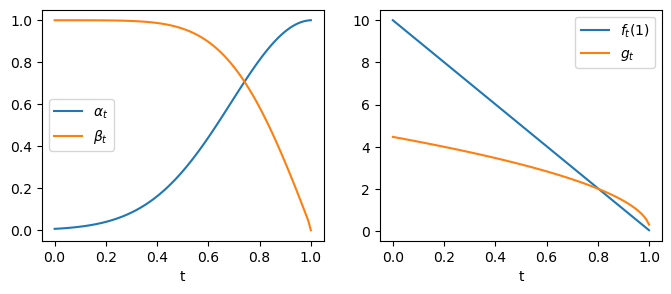

In [2]:
# @title Defining noise scheduling
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=100, pid=False)

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tlin, stoc.alpha(tlin), label="$\\alpha_t$")
plt.plot(tlin, stoc.beta(tlin), label="$\\beta_t$")
plt.xlabel("t"), plt.legend();

plt.subplot(122)
plt.plot(tlin, vmap(stoc.drift)(tlin, jnp.ones_like(tlin), None), label="$f_t(1)$")
plt.plot(tlin, vmap(stoc.diffusion)(tlin, jnp.ones_like(tlin), None), label="$g_t$")
plt.xlabel("t"), plt.legend();

In [3]:
n_samples = 10_000
base_samples = stoc.base.sample(n_samples, jr.key(0))
target_samples = stoc.target.sample(n_samples, jr.key(1))

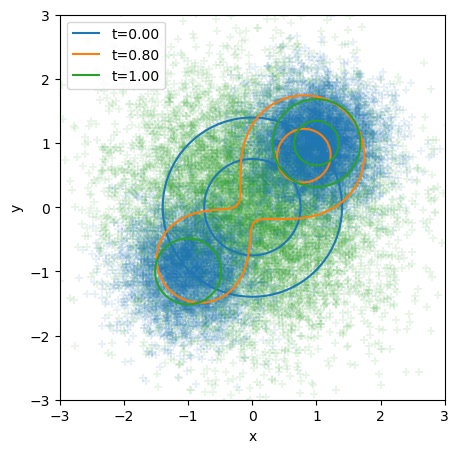

In [4]:
# @title Plot path
if stoc.dim == 1:
    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    tlin = jnp.linspace(0, 1, 7)[::-1]
    for t in tlin:
        stoc.plot_pdf(stoc.marg(t).log_prob, label=f't={t:.2f}')

    stoc.plot_pdf(tfd.Normal(loc=0., scale=1.).log_prob, ':k', label='standard');
    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend()

    plt.subplot(1,2,2)
    stoc.plot_margs()
    
elif stoc.dim == 2:
    plt.figure(figsize=(5,5))
    tlin = [0., 0.8, 1.]
    handles = []
    labels = []

    for it, t in enumerate(tlin):
        quad = stoc.plot_pdf(stoc.marg(t).log_prob, levels=2, colors=f'C{it}')
        handles.append(quad.legend_elements()[0][0])
        labels.append(f't={t:.2f}')

    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend(handles, labels);

Let's try to verify that our integration time is going to be good enough, by running backward and forward ODEs and SDEs. We should obtain base distribution for the backward ones, and the target distribution for the forward ones.

In [5]:
params = None # target
# params = stoc.params
seeds = jr.split(jr.key(0), n_samples)
ts_bsde, xs_bsde = stoc.backward_sde(seeds, target_samples)
ts_fsde, xs_fsde = stoc.forward_sde(params, seeds, base_samples)
ts_bode, xs_bode, _ = stoc.backward_ode(params, target_samples)
ts_fode, xs_fode, _ = stoc.forward_ode(params, base_samples)

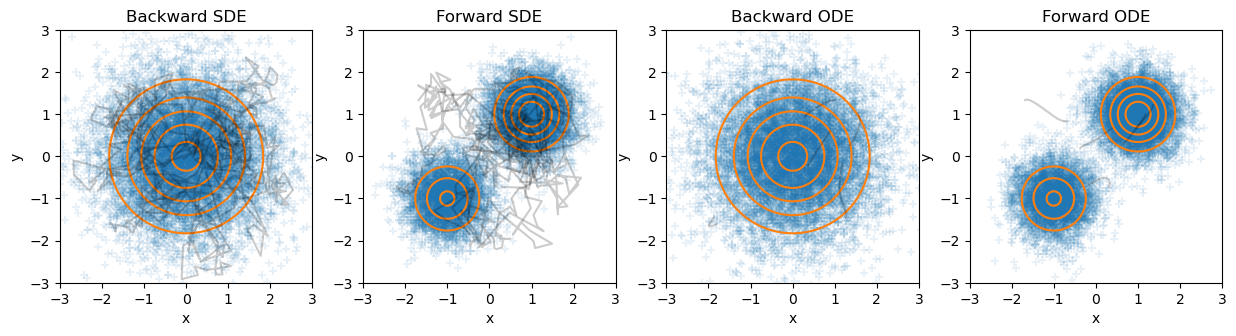

In [6]:
# @title Let's take a look at the trajectories
if stoc.dim == 1:
    n_traj = 100
    plt.figure(figsize=(14,6))
    plt.subplot(241)
    plt.plot(ts_bsde[:n_traj].T, xs_bsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(242)
    plt.plot(ts_fsde[:n_traj].T, xs_fsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward SDE')

    plt.subplot(243)
    plt.plot(ts_bode[:n_traj].T, xs_bode[:n_traj,:,0].T, 'k', alpha=0.1);    
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward ODE')

    plt.subplot(244)
    plt.plot(ts_fode[:n_traj].T, xs_fode[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward ODE');

    plt.subplot(245)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bsde[:,-1])

    plt.subplot(246)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fsde[:,-1])

    plt.subplot(247)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bode[:,-1])

    plt.subplot(248)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fode[:,-1])

elif stoc.dim == 2:
    n_traj = 5
    levels = 5
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bsde[:,-1], color='C0')
    plt.plot(*xs_bsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward SDE')

    plt.subplot(142)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fsde[:,-1], color='C0')
    plt.plot(*xs_fsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward SDE')

    plt.subplot(143)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bode[:,-1], color='C0')
    plt.plot(*xs_bode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward ODE');

    plt.subplot(144)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fode[:,-1], color='C0')
    plt.plot(*xs_fode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward ODE');

## 2 Score network and associated proposal probability
* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, i.e.$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) - \int^\tau_0 \nabla \cdot v_t(x(t))\dd t = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$For the ODE flow, we can integrate forward the probability flow starting at $x(0)$, while for the SDE flow we must integrate it backward since we do not know $x(0)$.
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t)$, i.e. $$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t$$

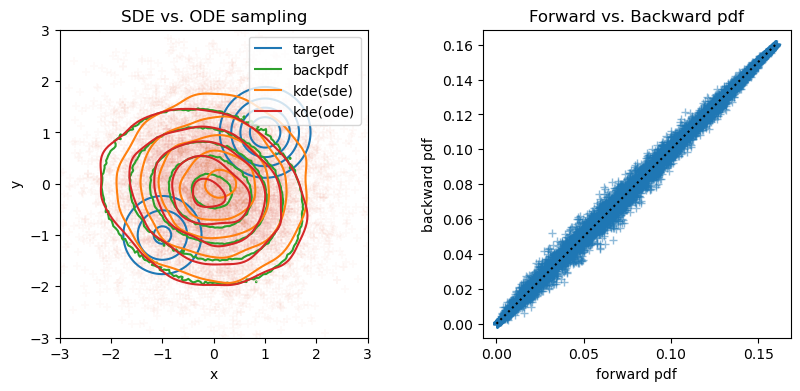

In [7]:
# @title Plot path
params = stoc.params
# params = None # target
n_samples = 10_000

def plot_results(params):
    seeds = jr.split(jr.key(0), n_samples)
    x1_sde = stoc.sample_sde(params, seeds)
    x1_ode, logp1f = stoc.sample_ode(params, seeds)
    logp1b = stoc.backward_logpdf(params, x1_ode)

    if stoc.dim == 1:
        stoc.plot_pdf(stoc.target.log_prob, 'C0', label='target')
        stoc.plot_pdf(partial(stoc._backward_logpdf, params), 'C2', label='backpdf')
        stoc.plot_kde(x1_sde, 'C1', label='kde(sde)')
        stoc.plot_kde(x1_ode, 'C3', label='kde(ode)')
        stoc.plot_samples(x1_sde, color='C1', alpha=0.1)
        stoc.plot_samples(x1_ode, color='C3', alpha=0.1)
        plt.legend()
        plt.title('SDE vs. ODE sampling')

    elif stoc.dim == 2:
        levels = 5
        handles = []
        labels = ['target', 'backpdf', 'kde(sde)', 'kde(ode)']

        quad = stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C0')
        handles.append(quad.legend_elements()[0][0])
        quad = stoc.plot_pdf(partial(stoc._backward_logpdf, params), levels=levels, colors='C2')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C1', alpha=0.01)
        quad = stoc.plot_kde(x1_sde, levels=levels, colors='C1')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C3', alpha=0.01)
        quad = stoc.plot_kde(x1_ode, levels=levels, colors='C3')
        handles.append(quad.legend_elements()[0][0])
        plt.legend(handles, labels)
        plt.title('SDE vs. ODE sampling')
    return x1_sde, x1_ode, logp1f, logp1b

plt.figure(figsize=(10,4))
plt.subplot(121)
x1_sde, x1_ode, logp1f, logp1b = plot_results(params)

plt.subplot(122)
p1f, p2f = jnp.exp(logp1f), jnp.exp(logp1b)
plt.plot(p1f, p2f, '+', alpha=0.5);
minmax = [min(p1f.min(), p2f.min()), max(p1f.max(), p2f.max())]
plt.plot(minmax, minmax, ':k')
plt.gca().set_aspect(1.)
plt.xlabel('forward pdf'), plt.ylabel('backward pdf');
plt.title('Forward vs. Backward pdf');

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - \alpha_t^{-1} v_{1}(x_1)}^2]$==?????==
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) }^2 + 2\nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{t}(x_t)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_t, x_1}[\norm{u^{\theta}_t(x_t) + \alpha_t^{-1}\log \pp_{1}(x_1)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM} = \nabla_\theta \cL_\mathrm{DFM}$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM} = \nabla_\theta \cL_\mathrm{TSM}$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

* Two ways, with $s_t(y_1,y_t) = \lambda_t \nabla\log\pp_1(x_1) + (1-\lambda_t)\nabla\log \pp_{t\mid 1}(y_t \mid y_1)$ (mixture DSM+TSM)
	* IS in loss$$\cL(\theta) := \EE_{t, y_1, y_t}[w(y_1) \norm{s^{\theta}_t(y_t) - s_t(y_1,y_t)}^2]$$
	* IS in target
$$\cL(\theta) := \EE_{t, y_1, y_t}[\norm{s^{\theta}_t(y_t) - \EE_{z_1\mid y_t}[w(z_1)s_t(z_1,z_t)]}^2]$$



In [21]:
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=100, pid=False)


def loss_sm(params, t, x1, z, score1, imp_weight):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)
    # gt = vmap(diffusion)(t, jnp.ones_like(t)[:,None], None)

    xt = alphat * x1 + betat * z
    score_est = vmap(partial(stoc.scorenn.apply, params))(t, xt)

    ##### Denoising Score Matching #####
    ## Default time weighting
    # error_dsm = (score_est + z / betat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2101.09258
    error_dsm = (score_est * betat + z)**2
    ## Maximum likelihood time weighting, see http://arxiv.org/abs/2101.09258
    # error_dsm = ((score_est + z / betat) * gt)**2

    ##### Target Score Matching #####
    ## Default time weighting
    # error_tsm = (score_est - score1 / alphat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    error_tsm = (score_est * alphat - score1)**2

    # return (error_dsm * imp_weight).mean()
    # return (error_tsm * imp_weight).mean()
    return ((error_dsm + error_tsm) * imp_weight).mean()


# Training loop
batch_size = 2**14
seed = jr.key(0)
losses = []
eval_per_esss = []
params = stoc.params
off_policy = True


# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-2
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
opt_state = optimizer.init(params)

# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)
    if off_policy:
        # Sample from proposal and compute importance weights
        # # Current SDE proposal
        # x1 = stoc.sample_sde(params, jr.split(seed_samp, batch_size)) # (batch_size, dim)
        # logprop = stoc.backward_logpdf(params, x1)

        # Current ODE proposal
        x1, logprop = stoc.sample_ode(params, jr.split(seed_samp, batch_size))

        # # Base proposal
        # x1 = stoc.base.sample(batch_size, seed_samp)
        # logprop = vmap(stoc.base.log_prob)(x1)
        # # logprop = vmap(stoc.marg(1.).log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(stoc.target.log_prob))(x1)
        imp_weight = logp1 - logprop # (batch_size,)
        
        # q01, q99 = jnp.quantile(imp_weight, jnp.array([0.01, 0.99]))
        # debug.print("\nweights: q01 {q01}, q99 {q99}", q01=q01, q99=q99)
        
        imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, 0.99)) # Clip too large weights
        # imp_weight = jnp.clip(imp_weight, max=jnp.quantile(imp_weight, 0.99)) # Clip too large weights
        imp_weight = jnp.exp(imp_weight - imp_weight.max())
        imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        # Sample from target directly
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(stoc.score_target)(x1)
        imp_weight = jnp.ones((batch_size, 1))

    # For importance weights such that E[W]=1, we have n/ESS = E[W^2] = Var[W] + 1
    # eval_per_ess = (imp_weight**2).mean()
    eval_per_ess = ((imp_weight / imp_weight.mean())**2).mean()

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_sm)(params, t, x1, z, score1, imp_weight)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, eval_per_ess)

In [ ]:
from jax.scipy.special import logsumexp
def loss_si(params, t, x1, z, seed_si):
    alphat = alpha(t)[:,None] # (batch_size, 1)
    betat = beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z
    score_est = vmap(partial(scorenn.apply, params))(t, xt)

    # imp_size = 1000
    # z1prop = jr.normal(seed_si, (imp_size,)+xt.shape)
    # x1prop = z1prop * betat + xt # (imp_size, batch_size, dim)

    # ##### Denoising Score Identity #####
    # # imp_weight = vmap(lambda x: target.log_prob(x / alphat))(x1prop) # (imp_size, batch_size)
    # imp_weight = vmap(vmap(lambda x, alpha: target.log_prob(x / alpha)))(x1prop, jnp.broadcast_to(alphat, x1prop.shape)) # (imp_size, batch_size)
    # imp_weight = jnp.exp(imp_weight - imp_weight.max(0)) # (imp_size, batch_size)
    # imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, batch_size, 1)
    # # # Default time weighting
    # # score_dsi = (-z1prop / betat * imp_weight).mean(0)
    # ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    # print(z1prop.shape, betat.shape, imp_weight.shape)
    # score_dsi = (-z1prop * betat * imp_weight).mean(0)

    # ##### Target Score Identity #####
    # # lse = lambda x: logsumexp(vmap(lambda xx: target.log_prob(xx / alphat))(x), axis=0)
    # lse = lambda x: logsumexp(vmap(vmap(lambda xx, alpha: target.log_prob(xx / alpha)))(x, jnp.broadcast_to(alphat, x.shape)), axis=0)
    # # lse = lambda x: logsumexp(vmap(vmap(target.log_prob(x / alphat))), axis=0)
    # # # Default time weighting
    # # score_tsi = grad(lse)(x1prop) / alphat
    # # Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    # score_tsi = vmap(grad(lse))(x1prop) * alphat


    def score_dsi(seed, xt, alphat, betat):
        imp_size = 10000
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        ##### Denoising Score Identity #####
        imp_weight = vmap(lambda x: target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = jnp.exp(imp_weight - imp_weight.max(0))
        imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, 1)
        # # Default time weighting
        score_dsi = (-z1prop / betat * imp_weight).mean(0)
        ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
        # score_dsi = (-z1prop * betat * imp_weight).mean(0)

        ##### Target Score Identity #####
        lse = lambda x: logsumexp(vmap(lambda zz: target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        # # Default time weighting
        score_tsi = grad(lse)(xt) / alphat
        # Equivalent to score_tsi = (vmap(grad(lambda x: target.log_prob(x / alphat)))(x1prop) * imp_weight).mean(0) / alphat
        # Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
        # score_tsi = grad(lse)(xt) * alphat

        # score_si = score_dsi + score_tsi
        score_si = score_dsi
        return score_si
    
    score_si = vmap(score_dsi)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)
    return ((score_est - score_si)**2).mean()


# Training loop
batch_size = 2**14
seed = jr.key(0)
losses = []
eval_per_esss = []
params = scorenn.init(jr.key(1), jnp.zeros(1), jnp.zeros(d))
off_policy = False

# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-3
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
opt_state = optimizer.init(params)

# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
    if off_policy:
        # Sample from proposal and compute importance weights
        ts, xs = sample_sde(params, jr.split(seed_samp, batch_size))
        x1 = xs[:,-1] # (batch_size, dim)
    else:
        # Sample from target directly
        x1 = target.sample(batch_size, seed_samp) # (batch_size, dim)

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=eps, maxval=1-eps)
    # t = jr.uniform(seed_time, (batch_size,), minval=1e-6, maxval=1-1e-6)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_si)(params, t, x1, z, seed_si)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, 1.)

Epoch 0, Loss: 4.10652, n/ESS: 5.60323, lr scale: 1.0
Epoch 10, Loss: 3.34796, n/ESS: 3.43146, lr scale: 1.0
Epoch 20, Loss: 3.22728, n/ESS: 2.70702, lr scale: 0.5
Epoch 30, Loss: 3.44309, n/ESS: 2.12676, lr scale: 0.25
Epoch 40, Loss: 3.38513, n/ESS: 4.03636, lr scale: 0.125
Epoch 50, Loss: 3.56067, n/ESS: 5.50470, lr scale: 0.0625
Epoch 60, Loss: 3.31402, n/ESS: 5.74646, lr scale: 0.03125
Epoch 70, Loss: 3.38116, n/ESS: 5.95422, lr scale: 0.015625
Epoch 80, Loss: 3.27349, n/ESS: 6.04581, lr scale: 0.0078125
Epoch 90, Loss: 3.37493, n/ESS: 6.03798, lr scale: 0.00390625
Epoch 100, Loss: 3.16702, n/ESS: 6.08272, lr scale: 0.001953125
Epoch 110, Loss: 3.33104, n/ESS: 6.20409, lr scale: 0.0009765625
Epoch 120, Loss: 3.43738, n/ESS: 6.11095, lr scale: 0.00048828125
Epoch 130, Loss: 3.29416, n/ESS: 6.19086, lr scale: 0.00048828125
Epoch 140, Loss: 3.33892, n/ESS: 6.11637, lr scale: 0.000244140625
Epoch 150, Loss: 3.38224, n/ESS: 6.16333, lr scale: 0.0001220703125
Epoch 160, Loss: 3.44648, n

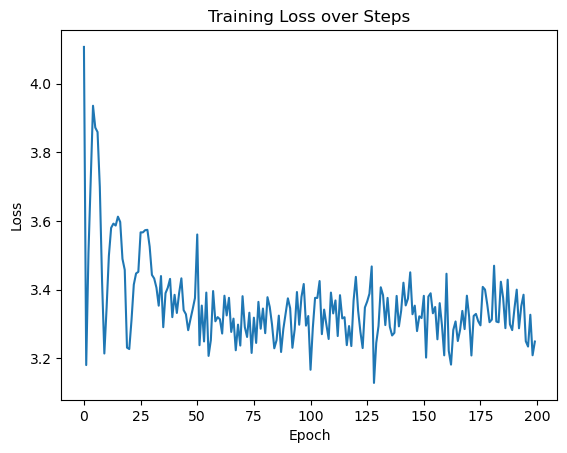

In [22]:
for epoch in range(200):
    seed, seed_train = jr.split(seed, 2)
    params, opt_state, (loss, eval_per_ess) = train_step(params, opt_state, seed)
    losses.append(loss)
    eval_per_esss.append(eval_per_ess)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")
        print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}, lr scale: {opt_state[1].scale}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

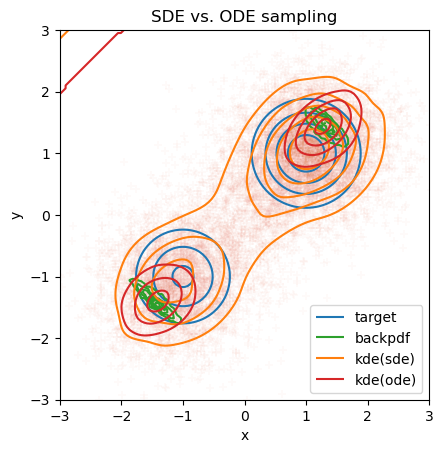

In [23]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params)